# Using LSTMs for supervised text classifcation

LSTM(Long Short-Term Memory)
is a type of recurrent neural network (RNN) designed to handle sequences (like text, speech, or time series) and to remember information over long time steps without suffering badly from the vanishing‑gradient problem

IMPORT LIBRARIES

In [23]:
import numpy as np
import pandas as pd
from keras.layers import TextVectorization
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import load_model
import matplotlib.pyplot as plt

In [29]:

df = pd.read_csv("/content/bbc-text.csv")
    # This dataset has two columns: "category", "text"

def get_labels(df):
    labels = {label: idx for idx, label in enumerate(df["category"].unique())}
    return labels

def get_stopwords():
    return ["the", "is", "and", "to", "of", "in", "that", "for", "on", "with"]

LOAD AND PREPARE THE DATASET

In [30]:
f = get_data()
label_dict = get_labels(df)

df["target"] = df["category"].map(label_dict)

texts = df["text"].values
targets = df["target"].values

x_train, x_test, y_train, y_test = train_test_split(
    texts, targets,
    test_size=0.2,
    random_state=42,
    stratify=targets
)

TOKENIZATION AND TEXT SEQUENCE

In [31]:
MAX_WORDS = 15000
MAX_SEQUENCE_LEN = 300

tokenizer = Tokenizer(num_words = MAX_WORDS)
tokenizer.fit_on_texts(x_train)

# covert text to sequences
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

# pad sequences
x_train_pad = pad_sequences(x_train_seq, maxlen = MAX_SEQUENCE_LEN)
x_test_pad = pad_sequences(x_test_seq, maxlen = MAX_SEQUENCE_LEN)

print("Shape of padded:", x_train_pad.shape)

Shape of padded: (1780, 300)


BUILD LSTM NETWORK

In [32]:
embedding_dim = 128
model = Sequential()
model.add(Embedding(MAX_WORDS, embedding_dim, input_length = MAX_SEQUENCE_LEN))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(128, dropout = 0.2, recurrent_dropout = 0.2))
model.add(Dense(len(label_dict), activation = "softmax"))

model.compile(
    loss = "sparse_categorical_crossentropy",
    optimizer = "adam",
    metrics = ["accuracy"]

)

model.build(input_shape = (None, MAX_SEQUENCE_LEN))

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 300, 128)       │     1,920,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_5             │ (None, 300, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,052,229 (7.83 MB)

 Trainable params: 2,052,229 (7.83 MB)

 Non-trainable params: 0 (0.00 B)

TRAIN THE MODEL WITH EARLY STOPPING

In [33]:
early_stop = EarlyStopping(
    monitor = "val_loss",
    patience = 3,
    restore_best_weights = True
)

history = model.fit(
    x_train_pad,
    y_train,
    epochs = 20,
    batch_size = 16,
    validation_split = 0.2,
    callbacks = [early_stop]
)

Epoch 1/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 69s 738ms/step - accuracy: 0.2583 - loss: 1.5908 - val_accuracy: 0.5112 - val_loss: 1.3003
Epoch 2/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 64s 715ms/step - accuracy: 0.5596 - loss: 1.1523 - val_accuracy: 0.6910 - val_loss: 1.0149
Epoch 3/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 81s 710ms/step - accuracy: 0.8130 - loss: 0.6341 - val_accuracy: 0.7556 - val_loss: 0.7191
Epoch 4/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 63s 708ms/step - accuracy: 0.8914 - loss: 0.3845 - val_accuracy: 0.7697 - val_loss: 0.7040
Epoch 5/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 62s 698ms/step - accuracy: 0.9569 - loss: 0.1990 - val_accuracy: 0.7472 - val_loss: 0.7260
Epoch 6/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 83s 707ms/step - accuracy: 0.9797 - loss: 0.1098 - val_accuracy: 0.8230 - val_loss: 0.5459
Epoch 7/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 83s 716ms/step - accuracy: 0.9918 - loss: 0.0501 - val_accuracy: 0.8006 - val_loss: 0.6015
Epoch 8/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 65s 728ms/step - accuracy: 0.9970 - loss: 0.0286 - val_accu

PLOT TRAINING HISTORY

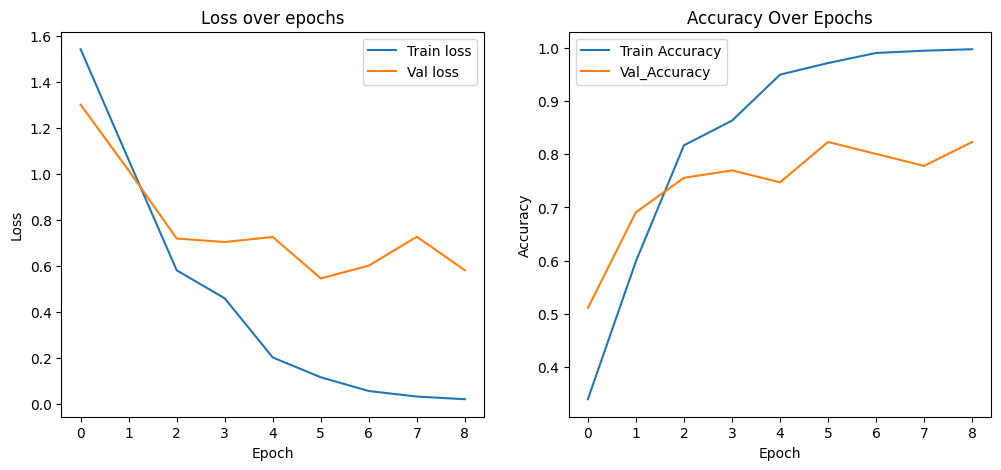

In [34]:
plt.figure(figsize = (12, 5))

# loss
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label = "Train loss")
plt.plot(history.history["val_loss"], label = "Val loss")
plt.title("Loss over epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label = "Train Accuracy")
plt.plot(history.history["val_accuracy"], label = "Val_Accuracy")
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

EVALUATE THE MODEL

In [35]:
y_pred_probs = model.predict(x_test_pad)
y_pred = np.argmax(y_pred_probs, axis = 1)

print("Classification Report: ")
print(classification_report(y_test, y_pred))

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step
Classification Report: 
              precision    recall  f1-score   support

           0       0.68      0.84      0.75        80
           1       0.86      0.84      0.85       102
           2       0.93      0.97      0.95       102
           3       0.97      0.84      0.90        77
           4       0.71      0.62      0.66        84

    accuracy                           0.83       445
   macro avg       0.83      0.82      0.82       445
weighted avg       0.84      0.83      0.83       445



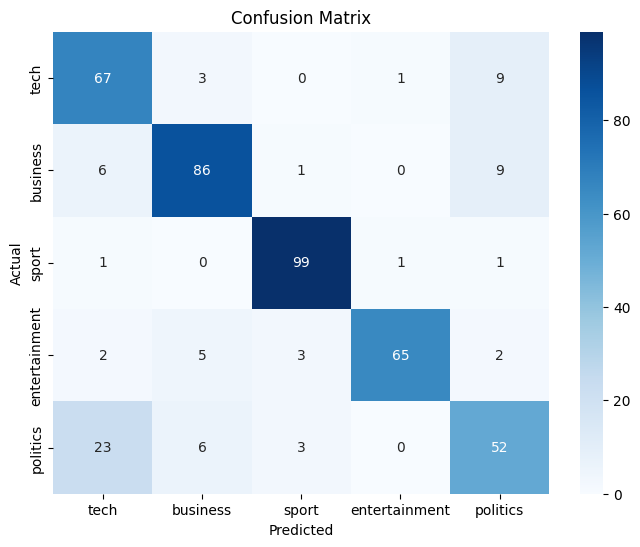

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Reverse label mapping to get readable class names
reverse_labels = {v: k for k, v in label_dict.items()}
class_names = [reverse_labels[i] for i in range(len(reverse_labels))]

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
